Minimal Viable Product for classifying flight delays using weather data.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('Illinois_2020_data.csv')

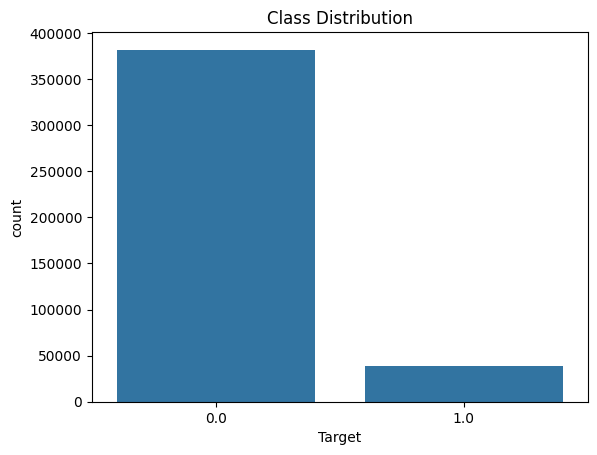

Proportion of Delayed Flights: 9.14%


In [ ]:
sns.countplot(data=df, x='Target')
plt.title('Class Distribution')
plt.show()
proportion_delayed = df['Target'].mean()
print(f"Proportion of Delayed Flights: {proportion_delayed:.2%}")

In [ ]:
print(df.columns)

Index(['Year', 'Quarter', 'Month', 'Day_of_Month', 'Day_of_Week',
       'Operating_Carrier_Code', 'Tail_Number', 'Origin_Airport_ID',
       'Origin_Airport_Code', 'Origin_State_Name', 'Destination_Airport_Code',
       'Destination_State_Name', 'Scheduled_Departure_Time',
       'Departure_Delay_Minutes', 'Taxi_Out_Time_Minutes',
       'Flight_Distance_Miles', 'Departure_Datetime',
       'Scheduled_Departure_Time_Minutes', 'Air_Temperature_Fahrenheit',
       'Dew_Point_Temperature_Fahrenheit', 'Relative_Humidity_Percent',
       'Wind_Direction_Degrees', 'Wind_Speed_Knots',
       'Hourly_Precipitation_Inches', 'Pressure_Altimeter_Inches',
       'Sea_Level_Pressure_Millibar', 'Visibility_Miles', 'Sky_Cover_Level_1',
       'Sky_Level_1_Altitude_Feet', 'Apparent_Temperature_Fahrenheit',
       'Target'],
      dtype='object')


Create a dataset with just the weather as predictors. Convert Sky_Cover_Level_1 into numerical variables

In [ ]:
weather_df = df.iloc[:, list(range(1, 5)) + list(range(18, 31))]
weather_df['Sky_Cover_Level_1'] = weather_df['Sky_Cover_Level_1'].astype('category').cat.codes
#weather_df['Sky_Cover_Level_1'].astype('category').cat.categories

<ipython-input-70-db98883b17aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['Sky_Cover_Level_1'] = weather_df['Sky_Cover_Level_1'].astype('category').cat.codes


Examine correlations

In [ ]:
correlation_matrix = weather_df.corr()

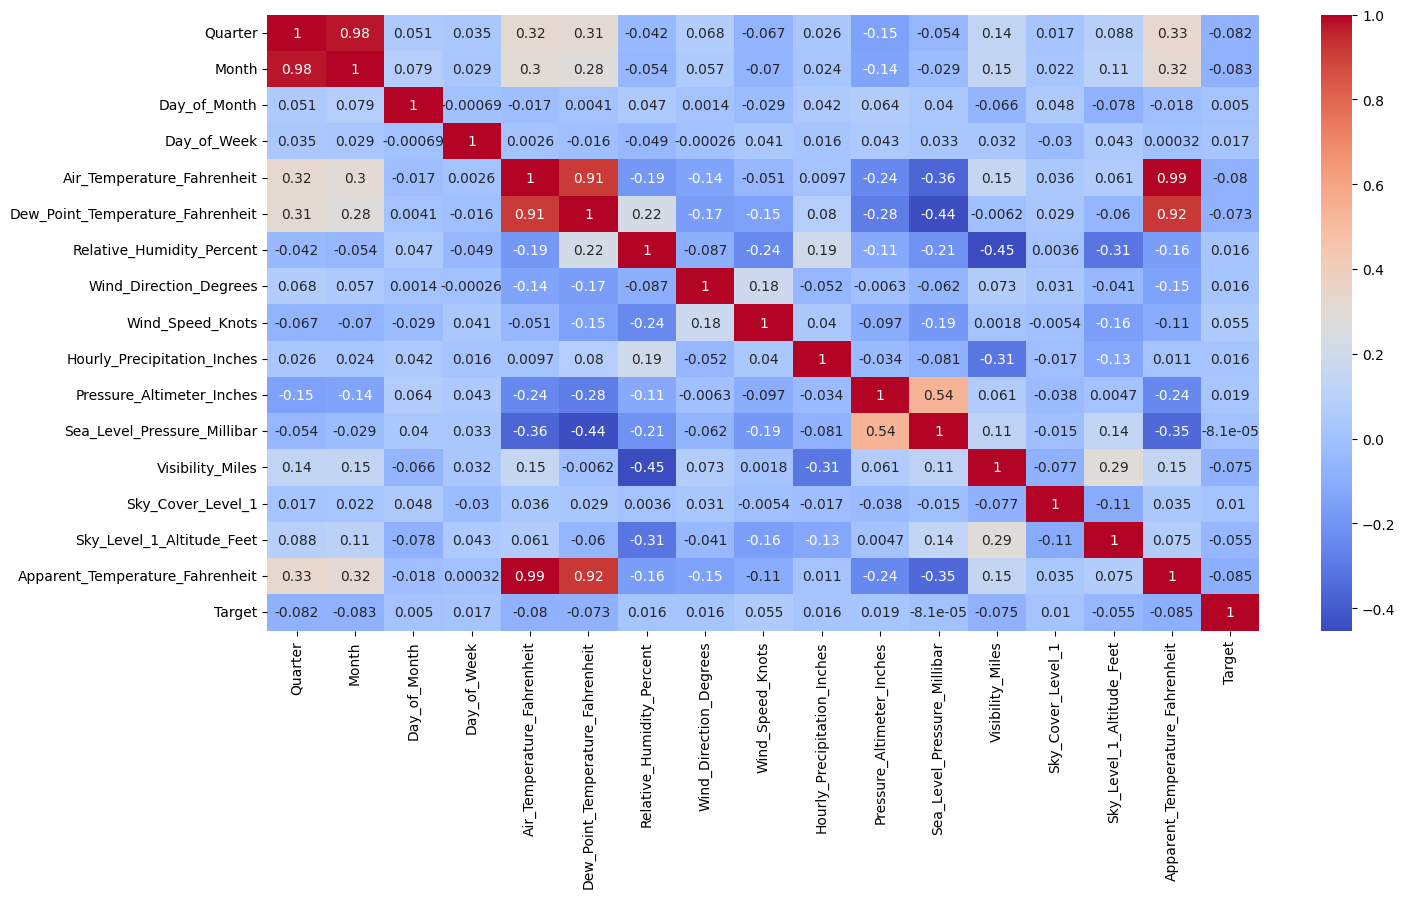

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [ ]:
weather_predictors = weather_df.drop('Target', axis=1)
target = df['Target']

Split weather-only data into training, testing, and validation sets using a 70/20/10 split

In [ ]:
# First, split into train and test/validation sets (70% train, 30% test/val)
train_df, test_val_df = train_test_split(weather_df, test_size=0.3, random_state=303)

# Then, split the test/val set into validation and test sets (2/3 validation, 1/3 test)
val_df, test_df = train_test_split(test_val_df, test_size=1/3, random_state=303)

x_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
x_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']

Fit a Logistic Regression model using the training set

In [ ]:
model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

Create predictions using the validation set and examine classification report and confusion matrix

In [ ]:
y_pred = model_LR.predict(x_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression Accuracy: 0.9067536362987121
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     76180
         1.0       0.00      0.00      0.00      7834

    accuracy                           0.91     84014
   macro avg       0.45      0.50      0.48     84014
weighted avg       0.82      0.91      0.86     84014



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


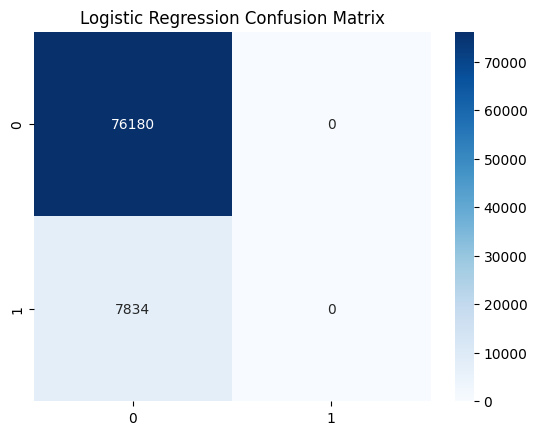

In [ ]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Unbalanced class distribution caused zero predictions for flight delays. Create new dataset that is balanced by upsampling

In [ ]:
# Separate majority and minority classes
df_majority = weather_df[weather_df['Target'] == weather_df['Target'].value_counts().idxmax()]
df_minority = weather_df[weather_df['Target'] == weather_df['Target'].value_counts().idxmin()]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,        # sample with replacement
                                 n_samples=len(df_majority),   # match majority class size
                                 random_state=303)     # for reproducibility

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Display new class distribution
print(df_balanced['Target'].value_counts())

Target
0.0    381693
1.0    381693
Name: count, dtype: int64


Split new upsampled dataset into training, testing, and validation sets

In [ ]:
# First, split into train and test/validation sets (70% train, 30% test/val)
b_train_df, b_test_val_df = train_test_split(df_balanced, test_size=0.3, random_state=303)

# Then, split the test/val set into validation and test sets (2/3 validation, 1/3 test)
b_val_df, b_test_df = train_test_split(b_test_val_df, test_size=1/3, random_state=303)

b_x_train = b_train_df.drop('Target', axis=1)
b_y_train = b_train_df['Target']
b_x_val = b_val_df.drop('Target', axis=1)
b_y_val = b_val_df['Target']

Try a logistic regression model on the balanced dataset

In [ ]:
b_model_LR = LogisticRegression(max_iter=1000)
b_model_LR.fit(b_x_train, b_y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
b_y_pred = b_model_LR.predict(b_x_val)
print("Logistic Regression Accuracy:", accuracy_score(b_y_val, b_y_pred))
print("Classification Report:\n", classification_report(b_y_val, b_y_pred))

Logistic Regression Accuracy: 0.5764456990902362
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.63      0.60     76762
         1.0       0.58      0.53      0.55     75915

    accuracy                           0.58    152677
   macro avg       0.58      0.58      0.58    152677
weighted avg       0.58      0.58      0.58    152677



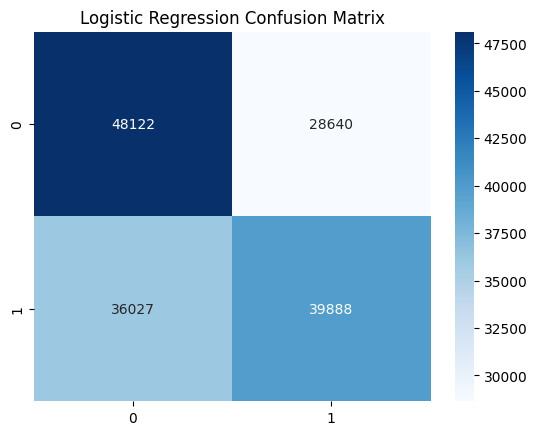

In [ ]:
sns.heatmap(confusion_matrix(b_y_val, b_y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [ ]:
cm = confusion_matrix(b_y_val,b_y_pred)
tn, fp, fn, tp = cm.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display results
print(f"Precision: {precision}")
print(f"Recall (TPR): {recall}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"Specificity (TNR): {specificity}")
print(f"F1 Score: {f1_score}")

True Negatives: 48122
False Positives: 28640
False Negatives: 36027
True Positives: 39888
Precision: 0.5820686434742003
Recall (TPR): 0.5254297569650267
False Positive Rate (FPR): 0.37310127406789817
Specificity (TNR): 0.6268987259321018
F1 Score: 0.5523009076244609


Try random forest classifier using the unbalanced dataset

Random Forest Accuracy: 0.9144666365129621
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     76180
         1.0       0.61      0.23      0.34      7834

    accuracy                           0.91     84014
   macro avg       0.77      0.61      0.64     84014
weighted avg       0.90      0.91      0.90     84014



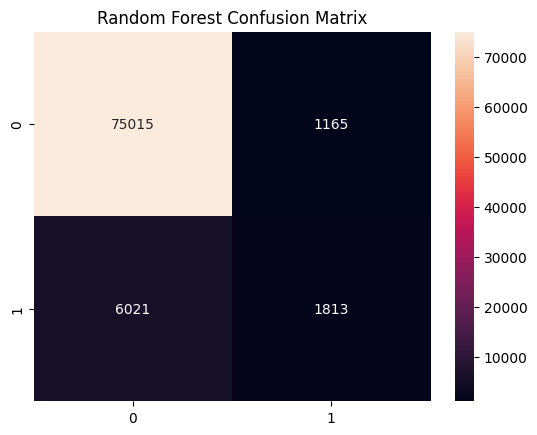

In [ ]:
# Initialize and fit the model
model_rf = RandomForestClassifier(random_state=303)
model_rf.fit(x_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(x_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
cm = confusion_matrix(y_val,y_pred_rf)
tn, fp, fn, tp = cm.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display results
print(f"Precision: {precision}")
print(f"Recall (TPR): {recall}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"Specificity (TNR): {specificity}")
print(f"F1 Score: {f1_score}")

True Negatives: 75015
False Positives: 1165
False Negatives: 6021
True Positives: 1813
Precision: 0.6087978509066487
Recall (TPR): 0.2314271125861629
False Positive Rate (FPR): 0.015292727750065634
Specificity (TNR): 0.9847072722499344
F1 Score: 0.3353681095079541


Try Random Forest Classifier on balanced dataset

Random Forest Accuracy: 0.8023539891404731
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.74      0.79     76762
         1.0       0.77      0.87      0.81     75915

    accuracy                           0.80    152677
   macro avg       0.81      0.80      0.80    152677
weighted avg       0.81      0.80      0.80    152677



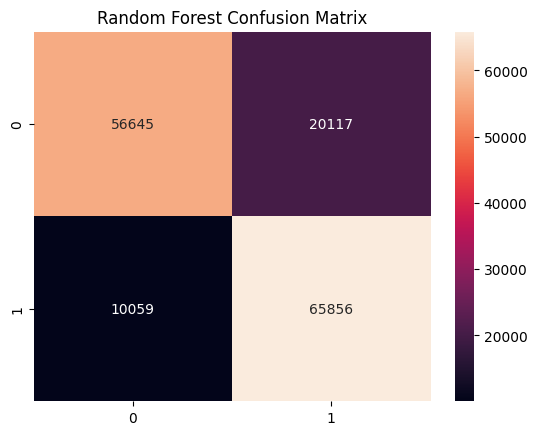

In [ ]:
# Initialize and fit the model
b_model_rf = RandomForestClassifier(random_state=303)
b_model_rf.fit(b_x_train, b_y_train)

# Predict and evaluate
b_y_pred_rf = b_model_rf.predict(b_x_val)
print("Random Forest Accuracy:", accuracy_score(b_y_val, b_y_pred_rf))
print("Classification Report:\n", classification_report(b_y_val, b_y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(b_y_val, b_y_pred_rf), annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
cm_rf = confusion_matrix(b_y_val,b_y_pred_rf)
tn, fp, fn, tp = cm_rf.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display results
print(f"Precision: {precision}")
print(f"Recall (TPR): {recall}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"Specificity (TNR): {specificity}")
print(f"F1 Score: {f1_score}")

True Negatives: 56645
False Positives: 20117
False Negatives: 10059
True Positives: 65856
Precision: 0.7660079327230642
Recall (TPR): 0.8674965421853389
False Positive Rate (FPR): 0.26206977410698
Specificity (TNR): 0.7379302258930199
F1 Score: 0.8135995255979442


Check Feature Importance

In [ ]:
X = df_balanced.drop('Target', axis=1)  # Replace 'target_column' with your actual target column name
y = df_balanced['Target']

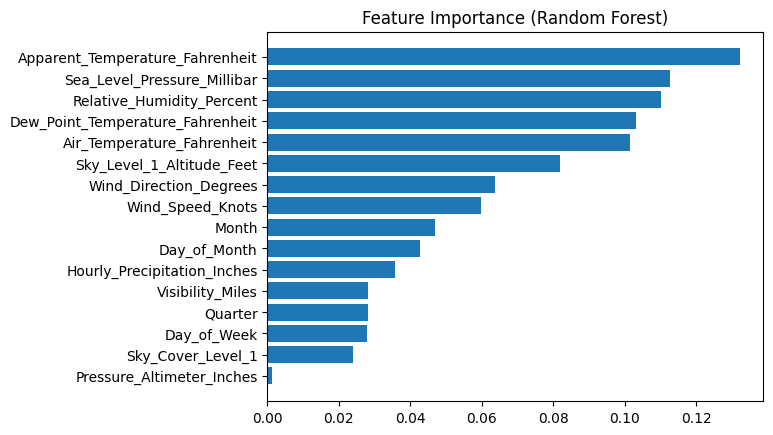

In [ ]:
feature_importances = b_model_rf.feature_importances_
features = X.columns

# Sort features by importance and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importance (Random Forest)')
plt.show()


Try Gradient Boosting model on balanced dataset

XGBoost Accuracy: 0.7086660073226485
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.76      0.72     76762
         1.0       0.73      0.66      0.69     75915

    accuracy                           0.71    152677
   macro avg       0.71      0.71      0.71    152677
weighted avg       0.71      0.71      0.71    152677



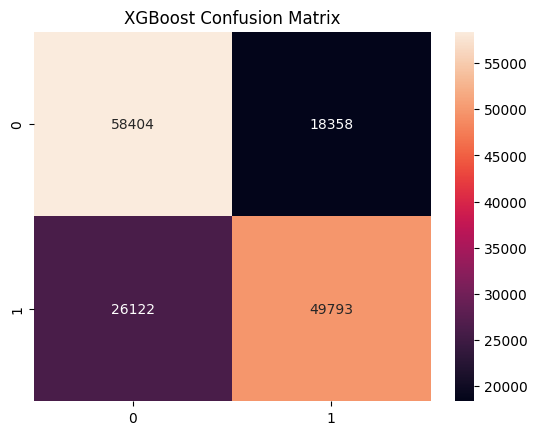

In [ ]:
b_model_xgb = XGBClassifier(random_state=303)
b_model_xgb.fit(b_x_train, b_y_train)
b_y_pred_xgb = b_model_xgb.predict(b_x_val)
print("XGBoost Accuracy:", accuracy_score(b_y_val, b_y_pred_xgb))
print("Classification Report:\n", classification_report(b_y_val, b_y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(b_y_val, b_y_pred_xgb), annot=True, fmt='d')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [ ]:
cm_xgb = confusion_matrix(b_y_val,b_y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display results
print(f"Precision: {precision}")
print(f"Recall (TPR): {recall}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"Specificity (TNR): {specificity}")
print(f"F1 Score: {f1_score}")

True Negatives: 58404
False Positives: 18358
False Negatives: 26122
True Positives: 49793
Precision: 0.7306275769981365
Recall (TPR): 0.6559046301784891
False Positive Rate (FPR): 0.23915479013053334
Specificity (TNR): 0.7608452098694667
F1 Score: 0.6912526203267947


Try Random Forest Classifier on Unbalanced Dataset

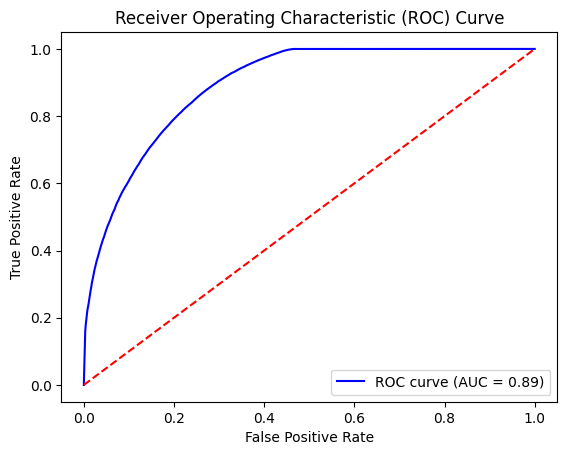

In [ ]:
# Assuming model, X_test, and y_test are already defined
y_scores = b_model_rf.predict_proba(b_x_val)[:, 1]  # Probability of positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(b_y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()